# 测试自己的fir_filtfilt
结果是比torchaudio的好

In [1]:
from CQT import CQTsmall, CQTsmall_fir
import torch
import numpy as np
import matplotlib.pyplot as plt

import tomllib
with open('../model/config.toml', 'br') as f:
    CQTconfig = tomllib.load(f)['CQT']
s_per_frame = CQTconfig['hop'] / CQTconfig['fs']

cqt = CQTsmall(
    fs = CQTconfig['fs'],
    fmin = CQTconfig['fmin'],
    octaves = CQTconfig['octaves'],
    bins_per_octave = CQTconfig['bins_per_octave'],
    hop = CQTconfig['hop'],
    filter_scale = CQTconfig['filter_scale'],
    requires_grad = False
)
cqt_fir = CQTsmall_fir(
    False,
    fs = CQTconfig['fs'],
    fmin = CQTconfig['fmin'],
    octaves = CQTconfig['octaves'],
    bins_per_octave = CQTconfig['bins_per_octave'],
    hop = CQTconfig['hop'],
    filter_scale = CQTconfig['filter_scale'],
    requires_grad = False
)

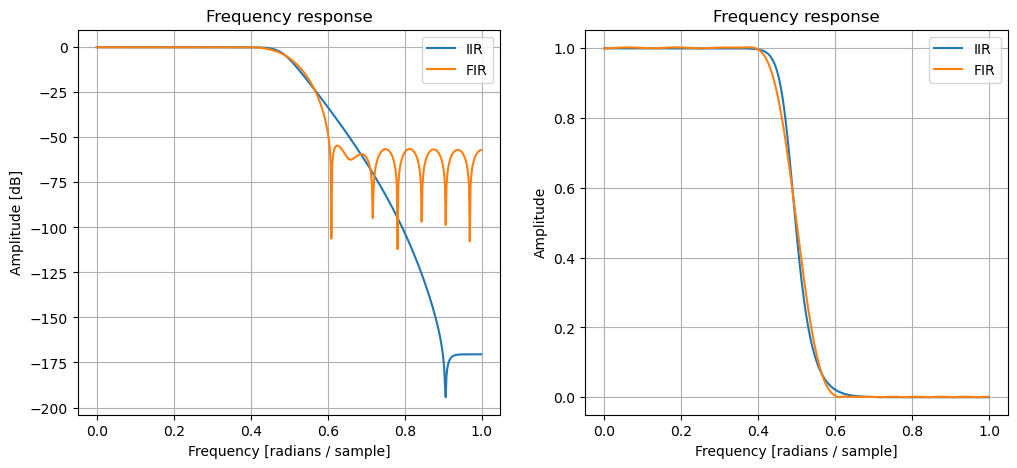

In [2]:
from scipy.signal import freqz

iir_den = cqt.iir_den.numpy()
iir_num = cqt.iir_num.numpy()
fir = cqt_fir.filtfilt.fir.squeeze().numpy()

w, h_iir = freqz(iir_num, iir_den)
w, h_fir = freqz(fir)
w /= np.pi

plt.figure(figsize=(12, 5))
subplt = plt.subplot(1, 2, 1)
plt.plot(w, 20 * np.log10(abs(h_iir)), label='IIR')
plt.plot(w, 20 * np.log10(abs(h_fir)), label='FIR')
plt.title('Frequency response')
plt.xlabel('Frequency [radians / sample]')
plt.ylabel('Amplitude [dB]')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(w, abs(h_iir), label='IIR')
plt.plot(w, abs(h_fir), label='FIR')
plt.title('Frequency response')
plt.xlabel('Frequency [radians / sample]')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()

plt.show()

In [28]:
randsig = torch.randn(1, 1, 128)
origin = cqt.anti_aliasing_filter(randsig)
my = cqt_fir.filtfilt(randsig)

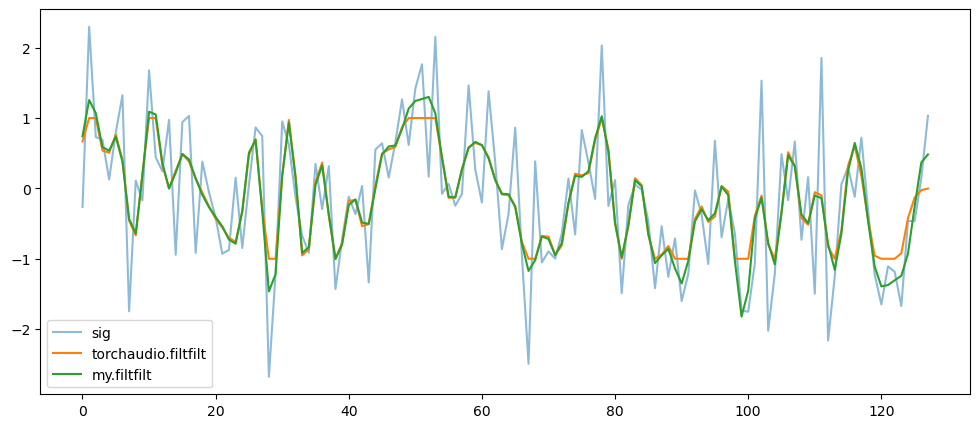

In [29]:

plt.figure(figsize=(12, 5))
plt.plot(randsig[0, 0].numpy(), alpha=0.5)
plt.plot(origin[0, 0].numpy())
plt.plot(my[0, 0].numpy())
plt.legend(["sig",'torchaudio.filtfilt', 'my.filtfilt'])
plt.show()

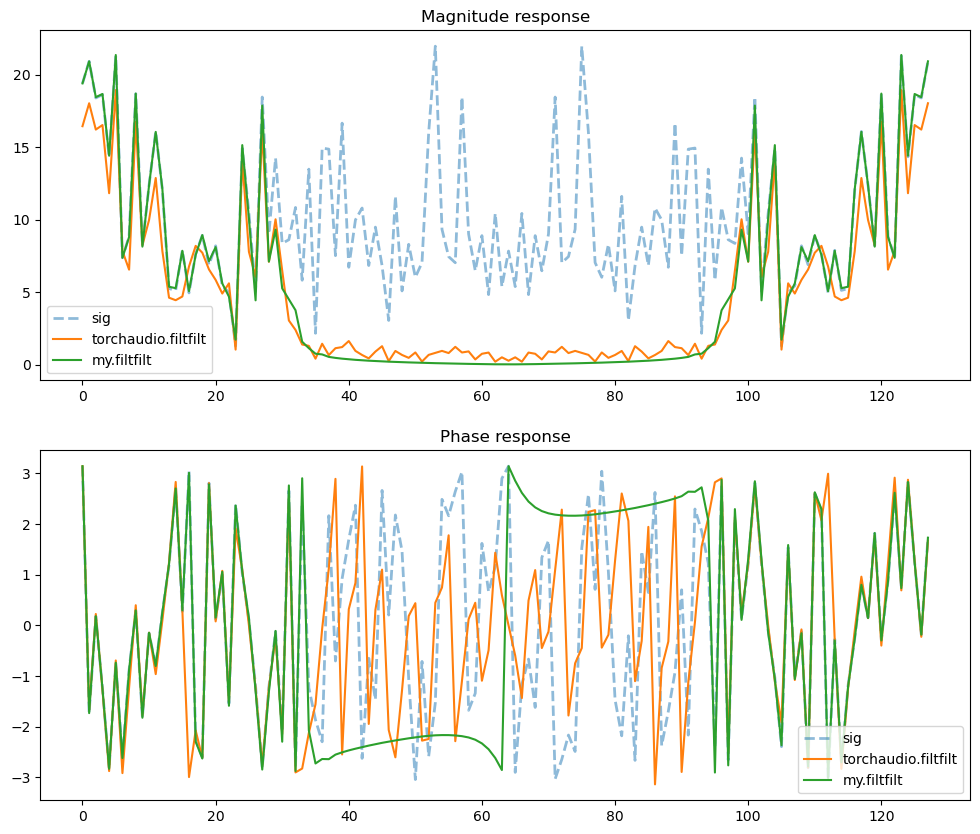

In [30]:
def freq_response(x):
    x = x.numpy()
    x = np.fft.fft(x)
    mag = np.abs(x)
    phase = np.angle(x)
    return mag, phase

rand_sig = freq_response(randsig[0, 0])
origin_sig = freq_response(origin[0, 0])
my_sig = freq_response(my[0, 0])

plt.figure(figsize=(12, 10))

plt.subplot(2, 1, 1)
plt.plot(rand_sig[0], alpha=0.5, linestyle='--', linewidth=2)
plt.plot(origin_sig[0])
plt.plot(my_sig[0])
plt.legend(["sig",'torchaudio.filtfilt', 'my.filtfilt'])
plt.title("Magnitude response")

plt.subplot(2, 1, 2)
plt.plot(rand_sig[1], alpha=0.5, linestyle='--', linewidth=2)
plt.plot(origin_sig[1])
plt.plot(my_sig[1])
plt.legend(["sig",'torchaudio.filtfilt', 'my.filtfilt'])
plt.title("Phase response")

plt.show()
